# Convolutional Neural Network

### Image data
* An image typically has 3 dimensions: width, height, and channels (ie the R, G, and B)

### The convolutional operation
* The convolutional operation has a window (typically of size 3x3 or 5x5) which scans across the image's surface
* The resulting chunks of the image are of the shape (NxNxNum_channels). The chunks dotted with a kernel array and an activation function is applied. The output has shape (1x1xN) where n is the number of convolutional neurons.
* The transformed patches are stitched back together to form an image-like 3D array, which is called the output feature map
* The convolutional operation is effective because 
  1. it can learn "spatial heirarchies" -- the idea that each item has distinct visual features which can be further broken down (Chollet, 2018, p. 123)
  2. it can recognize a pattern at any location because the same kernel is dotted with each patch of an image (Chollet, 2018, p. 123)

### The pooling operation (max-pooling)
* The pooling operation also uses windows (typically with a stride = to window size so that there is not overlap)
* A reduction operation is done on each window (max, mean etc) reducing the width and height but typically leaving the number of channels the same.
* The transformed windows are stitched back together to form an output map
* The pooling operation is needed so that
  1. Information from multiple areas is combined so that the next convolutional layer looks at a bigger area -- pooling layers effectively let us go up the spatial heirarchy (Chollet, 2018, p. 128)
  2. The number of coefficients is reduced (Chollet, 2018, p. 128)



<center>Resources</center>

Chollet, F. (2018). Deep learning with Python. Manning Publications Co

https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1985-IEEE_TSMC-Keller.pdf

In [3]:
import numpy as np

def relu(x):
    np.maximum(0, x)

def naive_convolutional_operation(image, patch_size, kernel, activation = relu,padding = False, strides = 1):
    #assert image.ndim == 3
    
    border_effect = patch_size // 2
    if padding:
        padded_shape = [image.shape[0] + 2*border_effect] + [image.shape[1] + 2*border_effect] + [image.shape[2]]     
        feature_map = np.zeros(padded_shape)
        feature_map[border_effect:border_effect+image.shape[0], border_effect:border_effect+image.shape[1],:] = image
    else:
        feature_map = np.array(image, copy = True)
    
    patches = []
    for i in np.arange(start = border_effect, stop = feature_map.shape[0] - border_effect, step = strides):
        for j in np.arange(start = border_effect, stop = feature_map.shape[1] - border_effect, step = strides):
            patches.append(feature_map[i-border_effect:(i+border_effect+1), j-border_effect:(j+border_effect+1)])
    
    out_map = []
    for patch in patches:
        out_map.append(activation(np.dot(patch, kernel)))
        
    out_map = np.array(np.split(np.array(out_map), (feature_map.shape[0] - border_effect*2) // strides))
    
    print(out_map.shape)
    
    return out_map

def max_pooling(patch):
    return np.max(patch, axis = (0,1))
    
    
def pooling(map_in, patch_size, stride, pooling_func):
    border_effect = patch_size - 1
    
    patches = []
    for i in np.arange(start = 0, stop = map_in.shape[0] - patch_size + 1, step = stride):
        for j in np.arange(start = 0, stop = map_in.shape[1] - patch_size + 1, step = stride):
            patches.append(map_in[i:i+patch_size,j:j+patch_size])
    print(len(patches))
    
    out_map = []
    for patch in patches:
        out_map.append(pooling_func(patch))
    
    out_map = np.array(np.split(np.array(out_map), (map_in.shape[0]) // stride))
    
    return out_map

In [24]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
import pathlib

datasets = pathlib.Path()

(x_train, y_train), (x_test, y_test) = mnist.load_data(path = 'mnist')

Text(0.5,1,'Original Image')

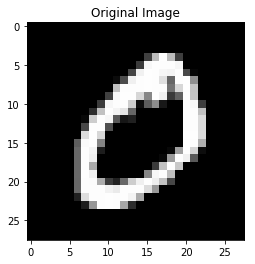

In [7]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1], cmap = 'Greys_r')
plt.title('Original Image')

Image is (28, 28) grayscale of 0 to 255 values
Output Shape: 
(26, 26, 3)


Text(0.5,1,'Image After Sample Convolutional Operation')

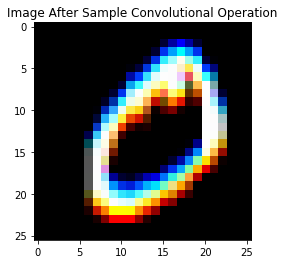

In [145]:
import numpy as np

print(f'Image is {x_train[1].shape} grayscale of {np.min(x_train[1])} to {np.max(x_train[1])} values')

ex_kernel = np.array([1, 0, 0])
print('Output Shape: ')
out = naive_convolutional_operation(x_train[1], 3, ex_kernel)

plt.imshow(out)
plt.title('Image After Sample Convolutional Operation')

169


Text(0.5,1,'Image After Max Pooling')

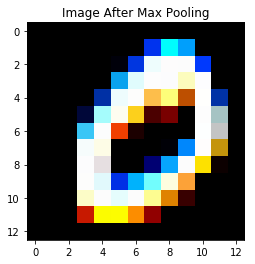

In [144]:
pooled = pooling(out, 2, 2, max_pooling)
pooled.shape
plt.imshow(pooled)

plt.title('Image After Max Pooling')

In [25]:
# Convnet
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical

# Standardize data
x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Just like in a perceptron, each layer is made up of units. This time, each unit performs a convolutional operations. 
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
model.add(layers.MaxPooling2D((2,2))) # Strides default to pool size
model.add(layers.Conv2D(64, (3,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3)))
# The output of the convnet, which has identified the features of the image is passed to a perceptron to classify.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

(60000, 28, 28) (60000, 10)
(10000, 28, 28) (10000, 10)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 576)               0         
________________________________________________________________

In [26]:
history = model.fit(x_train.reshape(*x_train.shape, 1), y_train, epochs = 5, batch_size = 64)

Epoch 1/5
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.1566 - acc: 0.9504
Epoch 2/5
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.0509 - acc: 0.9846
Epoch 3/5
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0375 - acc: 0.9884
Epoch 4/5
60000/60000 [==============================] - 66s 1ms/sample - loss: 0.0305 - acc: 0.9908
Epoch 5/5
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0232 - acc: 0.9929


In [27]:
print(x_test.shape, y_test.shape)
test_loss, test_acc = model.evaluate(x_test.reshape(*x_test.shape, 1), y_test)

(10000, 28, 28) (10000, 10)
10000/10000 [==============================] - 4s 433us/sample - loss: 0.0374 - acc: 0.9905


### 1. Type of Data
* Visual

### 2. Use Case
* In any visual processing task

### 3. Application
* Categorical identification of data

### 4. Basic Concept

##### The convolutional operation
* The convolutional operation has a window (typically of size 3x3 or 5x5) which scans across the image's surface
* The resulting chunks of the image are of the shape (NxNxNum_channels). The chunks dotted with a kernel array and an activation function is applied. The output has shape (1x1xN) where n is the number of convolutional neurons.
* The transformed patches are stitched back together to form an image-like 3D array, which is called the output feature map
* The convolutional operation is effective because 
  1. it can learn "spatial heirarchies" -- the idea that each item has distinct visual features which can be further broken down (Chollet, 2018, p. 123)
  2. it can recognize a pattern at any location because the same kernel is dotted with each patch of an image (Chollet, 2018, p. 123)

##### The pooling operation (max-pooling)
* The pooling operation also uses windows (typically with a stride = to window size so that there is not overlap)
* A reduction operation is done on each window (max, mean etc) reducing the width and height but typically leaving the number of channels the same.
* The transformed windows are stitched back together to form an output map
* The pooling operation is needed so that
  1. Information from multiple areas is combined so that the next convolutional layer looks at a bigger area -- pooling layers effectively let us go up the spatial heirarchy (Chollet, 2018, p. 128)
  2. The number of coefficients is reduced (Chollet, 2018, p. 128)

##### Categorization
* A simple dense neural network terminating in softmax activation can then take the output of the convnet and categorize it.

### 5. Assumptions
* There are spatial heirarchies

### 6. Existing solutions
* Keras, as seen above

### 7. Strengths and Weaknesses
#### Strengths
* Current benchmark for visual data

#### Weaknesses
* Opaque like most deep learning techniques
* Requires large amount of data